In [1]:
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import missingno as msno
import sentencepiece as spm
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Naver Movie Review Data Load

> 본 1장에서는 네이버 영화 리뷰의 데이터가 저장된 train, test 데이터를 메모리에 읽은 후, 데이터의 내용을 확인하는 과정을 기술한다.

## 1.1 Data Load

> 스토리지에 저장된 네이버 영화 리뷰 데이터를 메모리에 할당 후, 각 변수에 저장하는 작업을 진행한다.

In [3]:
train_data = pd.read_table(os.getenv('HOME')+'/aiffel/GoingNLP/Data/Lecture1/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingNLP/Data/Lecture1/ratings_test.txt')

## 1.2 View Data

### 1.2.1 Check Train Data

> 네이버 영화 리뷰의 훈련용 데이터 내용을 확인하는 작업을 진행한다.

In [4]:
print(len(train_data))
train_data[0:5]

150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


> 훈련용 데이터를 확인한 결과, 총 150,000여개의 데이터와 id, document, label 정보가 있음을 확인했다.

### 1.2.2 Check Test Data

In [5]:
print(len(test_data))
test_data[0:5]

50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


> 훈련용 데이터를 확인한 결과, 총 50,000여개의 데이터와 id, document, label 정보가 있음을 확인했다.

> 위 과정으로, 훈련용 데이터와 테스트용 데이터의 정보(id, decument, label)은 동일하며, 데이터 량이 3:1 비율임을 확인할 수 있다.

# 2. Data Preprocessing

> 본 2장에서는 데이터 분석에 앞서 데이터를 사전에 정제하는 과정을 진행한다.

## 2.1 Check missing values

> 본 2.1장에서는 불러온 데이터에 결측치가 있는지 수치적으로 확인하는 작업을 수행한다.

### 2.1.1 Check missing values in train dataset

<AxesSubplot:>

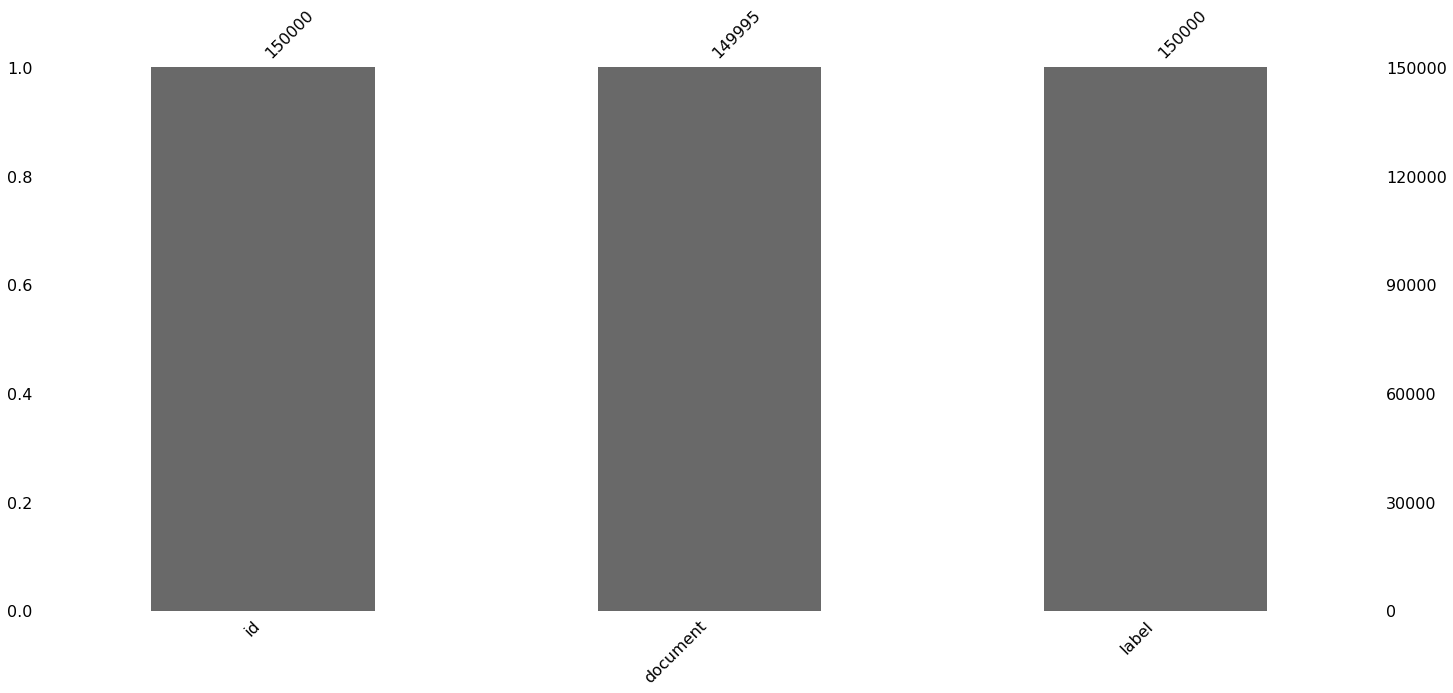

In [6]:
msno.bar(train_data)

> 수치적 분석에서 150,000여개 데이터 중 5개의 결측치가 확인되었다.

### 2.1.2 Check missing values in test dataset

<AxesSubplot:>

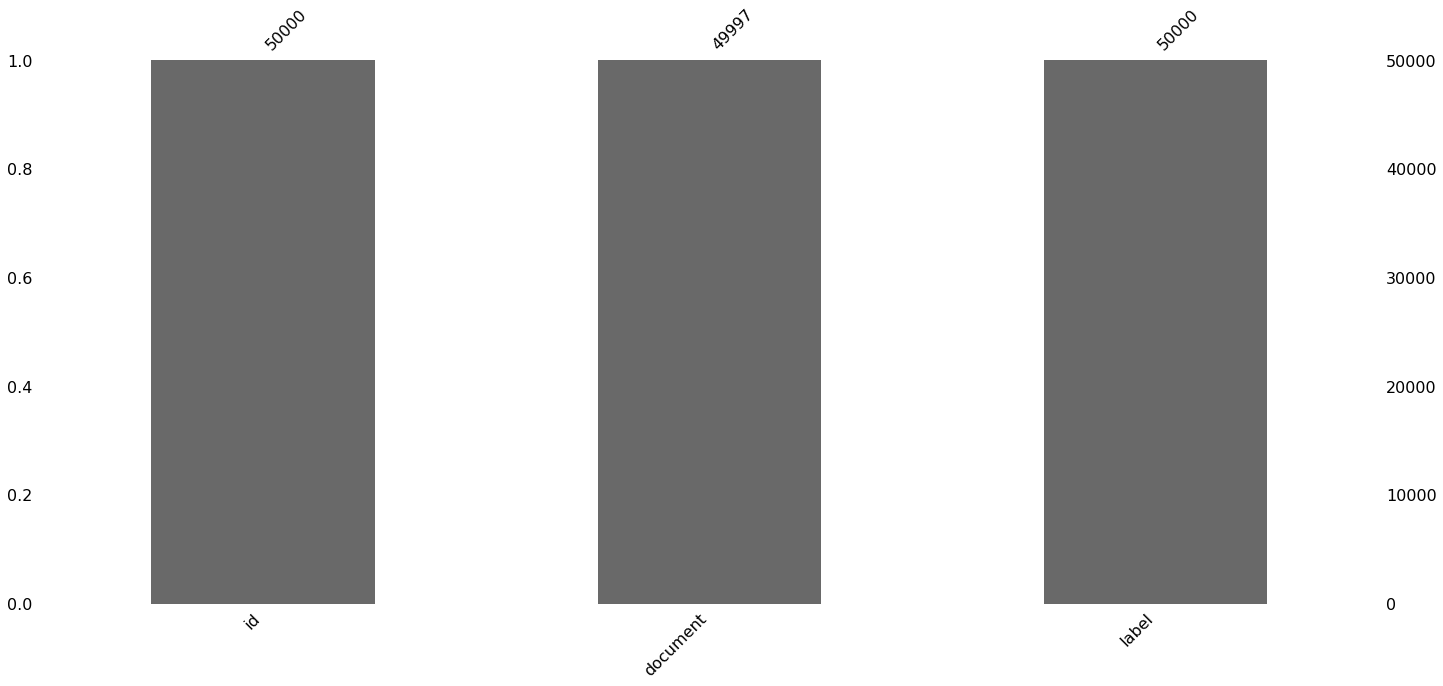

In [7]:
msno.bar(test_data)

> 수치적 분석에서 50,000여개 데이터 중 3개의 결측치가 확인되었다.

## 2.2 Remove missing data

> 본 2.2장에서는 위 2.1장에서 train data와 test data에서 확인한 결측치를 제거하는 작업을 진행한다.

In [8]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

print(len(train_data['document']))
print(len(test_data['document']))

149995
49997


> 결측치 제거 후 재 확인했을때, train 데이터셋과 test 데이터셋의 결측치가 없어졌음을 확인할 수 있다.

## 2.3 Deduplication

> 데이터 세트의 본문 내용에 중복되는 리뷰 데이터가 없도록 중복을 제거하는 작업을 진행한다.

In [9]:
train_data.drop_duplicates(["document"], inplace=True)
test_data.drop_duplicates(["document"], inplace=True)

In [10]:
print(len(train_data['document']))
print(len(test_data['document']))

146182
49157


> 중복 데이터를 제거한 결과는 아래와 같다.<br>
> <br>
> train_data - 149,995개 -> 146,182개<br>
> test_data - 49,997개 -> 49,157개

# 3. Data Analysis

> 본 3장에서는 데이터세트를 분석하고 모델의 목적에 맞도록 적절한 가공을 진행한다.

## 3.1 Check sentence length distribution

> 각 데이터셋의 문장 길이 분포를 확인하는 작업을 진행하기 위한 사용자 정의 함수를 구현한다.

In [11]:
def view_sentence_length_distribution(df_data):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in df_data:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // len(df_data))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in df_data:
        sentence_length[len(sen)-1] += 1
    
    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

### 3.1.1 train data

> 문장의 길이 분포를 시각화하여 출력하는 함수를 활용하여 train dataset을 확인한다.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


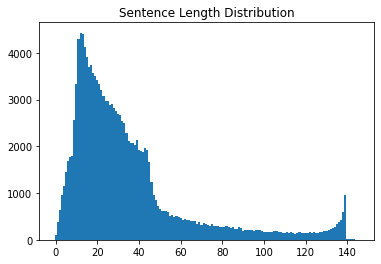

In [12]:
view_sentence_length_distribution(train_data['document'])

> train_data의 문장 최소 길이는 1이고, 최대 길이는 146이며, 문장의 평균 길이 35임을 확인할 수 있다.

### 3.1.2 test data

> 문장의 길이 분포를 시각화하여 출력하는 함수를 활용하여 test dataset을 확인한다.

문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 35


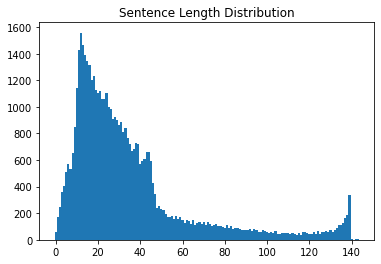

In [13]:
view_sentence_length_distribution(test_data['document'])

> test_data의 문장의 최소 길이는 1이고, 최대 길이는 144이며, 문장의 평균 길이 35임을 확인할 수 있다.

## 3.2 Data Purification

> 문장의 길이가 너무 짧으면 노이즈가 될 수 있으므로, 길이가 10 미만인 데이터는 제거하도록 한다.<br>
> 문장의 길이가 너무 길면 모델의 복잡도(연산량)이/가 비효율적으로 증가하므로 길이가 70을 초과한 데이터는 제거하도록 한다.<br>
> 이를 위한, 조건 이내의 문장 길이를 가진 데이터를 추출하여 반환하는 사용자 정의 함수를 구현한다.

In [14]:
def sentence_lenght_limit(df_data, sentence_min, sentence_max):
    # step1. 문장 길이 제한
    doc = []
    for s in df_data['document']:
        if(len(s) <= sentence_max and len(s) >= sentence_min):
            doc.append(s)
    
    # step2. list to pd.DataFrame convert 
    temp_data = pd.DataFrame(dict.fromkeys('d', doc))
    temp_data.rename(columns = {'d' : 'document'}, inplace = True)
    
    # step3. 조건 내 값 병합
    df_data = pd.merge(df_data, temp_data, on='document')        
    df_data.rename(columns={'id_x':'id'})
    df_data.rename(columns={'label_x':'label'})
    
    # step4. 데이터 중복 제거
    df_data.drop_duplicates(subset=['document'], inplace=True)

    return df_data

### 3.2.1 train data

> 조건 이내의 문장 길이를 가진 데이터를 추출하여 반환하는 함수를 활용하여  train dataset을 확인한다.

In [15]:
train_data = sentence_lenght_limit(train_data, 10, 70)

> 사용자 정의 함수로 가공하여 추출된 train dataset을 확인한다.

In [16]:
train_data[-5:]

,id,document,label
119786,6222902,인간이 문제지.. 소는 뭔죄인가..,0
119787,8549745,평점이 너무 낮아서...,1
119788,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
119789,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
119790,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


> 조건 이내의 데이터만 추출한 결과 기존 146,182개의 데이터 중 119,791개의 데이터가 확보되었음을 확인할 수 있다.<br>
> 위 데이터의 문장 길이 분포를 시각화하여 확인한 결과는 아래와 같다.

문장의 최단 길이: 10
문장의 최장 길이: 70
문장의 평균 길이: 28


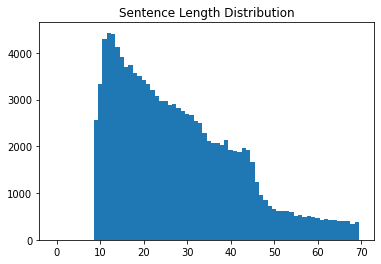

In [17]:
view_sentence_length_distribution(train_data['document'])

> 가공된 train_data의 문장의 최소 길이는 10이고, 최대 길이는 70이며, 문장의 평균 길이 28임을 확인할 수 있다.

### 3.2.2 test data

> 조건 이내의 문장 길이를 가진 데이터를 추출하여 반환하는 함수를 활용하여  test dataset을 확인한다.

In [18]:
test_data = sentence_lenght_limit(test_data, 10, 70)

> 사용자 정의 함수로 가공하여 추출된 test dataset을 확인한다.

In [19]:
test_data[-5:]

,id,document,label
40021,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
40022,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
40023,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
40024,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
40025,6070594,마무리는 또 왜이래,0


> 조건 이내의 데이터만 추출한 결과 기존 49,157개의 데이터 중 40,026개의 데이터가 확보되었음을 확인할 수 있다.<br>
> 위 데이터의 문장 길이 분포를 시각화하여 확인한 결과는 아래와 같다.

문장의 최단 길이: 10
문장의 최장 길이: 70
문장의 평균 길이: 28


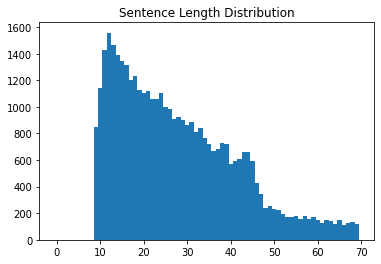

In [20]:
view_sentence_length_distribution(test_data['document'])

> 가공된 test_data의 문장의 최소 길이는 10이고, 최대 길이는 70이며, 문장의 평균 길이 28임을 확인할 수 있다.

# 4. Sentence piece Model Train

> 본 4장에서는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer인 SentencePiece모델을 학습하는 과정을 기술한다.

## 4.1 Setting Data

> 훈련한 모델을 저장할 경로와, 단어 사전의 크기를 설정하고, 모델 학습을 위해 데이터셋에 개행문자를 추가하는 작업을 진행한다.

In [21]:
temp_file = os.getenv('HOME')+'/aiffel/GoingNLP/Data/Lecture1/korean-english-park.train.ko.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:
        f.write(str(row) + '\n')

## 4.2 Model Train

> 위 과정으로 정제한 데이터를 활용하여 Sentence Piece 모델을 학습한다.

In [22]:
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size))

> 학습한 모델이 지정한 경로에 저장되었는지 확인한다.

In [23]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 375267 Dec 16 04:56 korean_spm.model
-rw-r--r-- 1 root root 144698 Dec 16 04:56 korean_spm.vocab


> 설정한 경로에 학습된 모델과 단어 사전이 잘 저장되었음을 확인할 수 있다.

## 4.3 Model Test

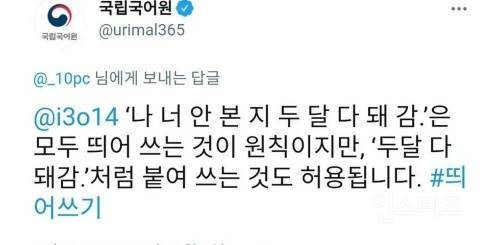

> 한국인들도 의견이 분분했던 '너나본지두달다돼감' 문장을 활용하여 학습된 Sentence piece Model이 올바르게 분석하는지 확인하는 실험을 진행한다.

In [24]:
s = spm.SentencePieceProcessor()
s.Load(os.getenv('HOME')+'/aiffel/GoingNLP/korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('너나본지두달다돼감.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('너나본지두달다돼감.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1028, 33, 246, 19, 295, 517, 17, 2018, 210, 4]
['▁너', '나', '본', '지', '두', '달', '다', '돼', '감', '.']
너나본지두달다돼감.


> 국립국어원 못지 않은 단어 분석 성능을 보여주었다.

# 5. Tokenizer

> 본 5장에서는 4장에서 학습한 Sentence piece Model을 활용하여 Tokenizer을 생성하는 과정을 기술한다.

## 5.1 Create Tokenizer Function

> 4장에서 훈련시킨 Sentence Piece Model을 활용하여 Tokenizer 기능을 수행하는 사용자 정의 함수를 구현한다.<br>
> 문장 길이 차이에 따른 패딩은 뒷 부분을 0으로 보충하는 'Post'를 사용한다.

In [25]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

## 5.2 make dataset

> 위 사용자 정의 함수를 활용하여 모델 학습 및 검증에 사용할 train, val, test 데이터셋을 확보하는 작업을 진행한다.

### 5.2.1 make train and test dataset

> sp_tokenize 함수를 활용하여 model 학습에 사용할 train, test 데이터와 token 확인을 위한 word to index 데이터를 확보한다.

In [26]:
# Tokenizer using the Sentence Piece model
train_tensor , train_word_index, _ = sp_tokenize(s, train_data['document'])
test_tensor, _, _ = sp_tokenize(s, test_data['document'])

In [27]:
X_train = train_tensor
y_train = np.array(train_data["label"])

X_test = test_tensor
y_test = np.array(test_data["label"])

word_to_index = train_word_index

### 5.2.2 Make validation dataset

> 훈련할 모델의 성능을 검증하기 위한 검증용 데이터와 모델 훈련에 사용할 데이터를 분리하는 작업을 진행한다.<br>
> train 데이터에는 총 119,791개의 데이터가 있고, 이를 훈련용 데이터셋(80%), 검증용 데이터셋(20%)비율로 나누는 작업을 진행한다.

In [28]:
x_train_set, x_val_set, y_train_set, y_val_set = train_test_split(X_train, y_train, test_size=0.2, random_state=1996)

## 5.3 Check token and dataset

> 토크나이저 작업 결과를 확인하고 모델에 사용할 텐서의 차원수를 확인하는 작업을 진행한다.

In [29]:
for index, value in word_to_index.items():
    if index > 30:
        break
        
    print("{} : {}".format(index, value))

0 : <unk>
1 : <s>
2 : </s>
3 : ▁
4 : .
5 : ..
6 : 이
7 : ▁영화
8 : ...
9 : 의
10 : 가
11 : 도
12 : 는
13 : ,
14 : 을
15 : 에
16 : 고
17 : 다
18 : 은
19 : 지
20 : ?
21 : !
22 : 한
23 : ▁너무
24 : ▁정말
25 : 만
26 : 를
27 : ▁이
28 : 로
29 : ▁진짜
30 : ~


> 's', '/s' 으로 시작 토큰과 종료 토큰이 생성되었음을 확인할 수 있고, 단어 단위로 분절되어 있음을 확인할 수 있다.

In [30]:
print("훈련용 데이터 : ",x_train_set.shape)
print("검증용 데이터 : ",x_val_set.shape)
print("\n")
print("훈련용 라벨 데이터 : ",y_train_set.shape)
print("검증용 라벨 데이터 : ",y_val_set.shape)

훈련용 데이터 :  (95832, 63)
검증용 데이터 :  (23959, 63)


훈련용 라벨 데이터 :  (95832,)
검증용 라벨 데이터 :  (23959,)


> 훈련용과 검증용 데이터는 각각, 95,832개 23,959개로 구성되었으며, 모두 63차원으로 구성되었음을 확인할 수 있다.

# 6. Model Design

> 본 6장에서는 한국어 텍스트를 학습할 모델을 설계하는 과정을 기술한다.<br>

## 6.1 LSTM model design

> 본 데이터 세트는 63차원이라는 깊은 차원의 구조를 가지고 있다.<br>
> 이에, RNN 모델 중 길이가 긴 문장에서 강점을 보이는 LSTM 모델을 활용하여 모델을 구성한다.<br>
> <br>
> word_vector_dim을 최대 문장 길이와 같은 63차원으로 설정하여 임베딩 레이어를 실행한다.<br>
> LSTM의 state vector는 2의 제곱이면서, 최대 문장 길이의 절반과 유사한 32 차원으로 설정하고 이에 맞추어 Dense도 32로 설정한다.<br>
> 결과가 True, False를 나타내는 (1,0),  2가지 뿐 이므로 출력 레이어의 Dense 1로 설정하고 활성화 함수를 시그모이드로 설정한다.

In [31]:
word_vector_dim = 63

LSTM_model = keras.Sequential()
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(32))
LSTM_model.add(keras.layers.Dense(32, activation='tanh'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 63)          504000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12288     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 517,377
Trainable params: 517,377
Non-trainable params: 0
_________________________________________________________________


> LSTM 모델 디자인 결과, 517,377개의 파라미터를 훈련해야함을 확인할 수 있다.

## 6.2 LSTM Model train

> 옵티마이저는 가중치의 방향과 step_size를 학습 결과에 따라 적절하게 조정하기 위해 'adam'을 설정하였다.<br>
> 결과가 True or False인 이진 분류 이므로 loss는 'binary_crossentropy'으로 설정하였다.<br>
> metrics는 정확도를 기준으로 20회 학습을 진행한다.<br>

In [63]:
epochs=20

In [54]:
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_history = LSTM_model.fit(x_train_set, y_train_set, epochs=epochs, batch_size=512, validation_data=(x_val_set, y_val_set), verbose=1)

Epoch 1/20
188/188 [==============================] - 6s 24ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 3/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 4/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 5/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6921 - accuracy: 0.5010 - val_loss: 0.6250 - val_accuracy: 0.6734
Epoch 6/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6409 - accuracy: 0.6440 - val_loss: 0.6760 - val_accuracy: 0.5501
Epoch 7/20
188/188 [==============================] - 4s 22ms/step - loss: 0.6703 - accuracy: 0.5584 - val_loss: 0.6688 - val_accuracy: 0.5648

## 6.3 LSTM Model Visualization&Test

> 모델의 학습 과정을 시각적으로 확인하고, 모델의 성능을 테스트 하는 과정을 기술한다.

### 6.3.1 Visualization

> Model의 학습 과정을 시각적으로 확인할 수 있는 사용자 정의 함수를 구현한다.

In [32]:
def line_plot(epoch, history, list_of_metrics):
    
    fig, ax = plt.subplots(1,2)
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = history[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epoch, y, label="train")
                else:
                    ax[i].plot(epoch, y, label="validation")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = history[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epoch, y, label="train")
                    else:
                        ax[i].plot(epoch, y, label="validation")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

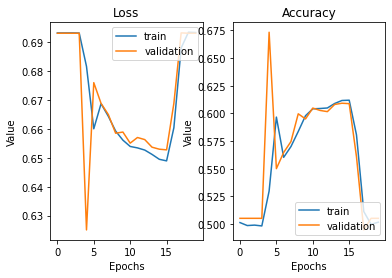

In [55]:
line_plot(LSTM_history.epoch, LSTM_history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

> Accuracy, loss 그래프 모두 학습이 불안정하며, 학습이 잘 되지 않는 모습을 보여주고 있다.

### 6.3.2 Test

In [39]:
LSTM_model.evaluate(X_test, y_test)

1251/1251 [==============================] - 6s 5ms/step - loss: 0.6642 - accuracy: 0.5808


[0.66415935754776, 0.5808224678039551]

> 학습된 LSTM 모델 성능을 테스트한 결과 loss는 0.6이나, 정확도는 58%라는 낮은 성능을 보여주었다.

> 위 과정을 통해 수치적 기록과, 시각적 기록 모두 LSTM 모델이 제대로 학습되지 않고 성능도 낮은 모습을 보여주었다.
> 

# 7. Other Model

> 자연어 처리에 강점을 보여주는 LSTM 모델이 Sentence piece 토큰 학습을 잘 하지 못하는 모습을 보여주었다.<br>
> 이에, Maxpool1D 와 Convolution 1D 모델을 활용하여 Sentence piece 토큰을 학습하고 결과를 확인하고자 한다. 

## 7.1 Maxpool1D_model

In [34]:
Maxpool1D_model = keras.Sequential()
Maxpool1D_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Maxpool1D_model.add(keras.layers.GlobalMaxPooling1D())
Maxpool1D_model.add(keras.layers.Dense(16, activation='tanh'))
Maxpool1D_model.add(keras.layers.Dense(1, activation='sigmoid'))

Maxpool1D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 63)          504000    
_________________________________________________________________
global_max_pooling1d (Global (None, 63)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1024      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 505,041
Trainable params: 505,041
Non-trainable params: 0
_________________________________________________________________


> Maxpool1D 모델을 설계한 결과, 505,041개의 파라미터를 훈련해야함을 확인할 수 있다.

In [57]:
Maxpool1D_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Maxpool1D_history = Maxpool1D_model.fit(x_train_set, y_train_set, epochs=epochs, batch_size=512, validation_data=(x_val_set, y_val_set), verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 13ms/step - loss: 0.6272 - accuracy: 0.6839 - val_loss: 0.3756 - val_accuracy: 0.8363
Epoch 2/20
188/188 [==============================] - 2s 13ms/step - loss: 0.3217 - accuracy: 0.8657 - val_loss: 0.3455 - val_accuracy: 0.8484
Epoch 3/20
188/188 [==============================] - 2s 13ms/step - loss: 0.2641 - accuracy: 0.8934 - val_loss: 0.3519 - val_accuracy: 0.8475
Epoch 4/20
188/188 [==============================] - 2s 13ms/step - loss: 0.2211 - accuracy: 0.9151 - val_loss: 0.3661 - val_accuracy: 0.8463
Epoch 5/20
188/188 [==============================] - 2s 12ms/step - loss: 0.1879 - accuracy: 0.9312 - val_loss: 0.3915 - val_accuracy: 0.8423
Epoch 6/20
188/188 [==============================] - 2s 13ms/step - loss: 0.1534 - accuracy: 0.9481 - val_loss: 0.4227 - val_accuracy: 0.8426
Epoch 7/20
188/188 [==============================] - 2s 13ms/step - loss: 0.1204 - accuracy: 0.9625 - val_loss: 0.4694 - val_accuracy: 0.8383

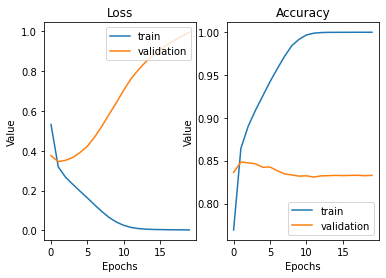

In [58]:
line_plot(Maxpool1D_history.epoch, Maxpool1D_history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

> train의 Accuracy, loss 그래프 모두 안정적인 학습 과정을 보여주었다.<br>
> 그러나, validation의  Accuracy, loss 그래프에서 수렴도은 안정적이었으나, 성능에서는 잘 개선되지 않는 모습을 보여주고 있다.

In [66]:
Maxpool1D_model.evaluate(X_test, y_test)

1251/1251 [==============================] - 3s 3ms/step - loss: 1.0366 - accuracy: 0.8268


[1.0366066694259644, 0.8268125653266907]

> 학습된 Maxpool 1D 모델 성능을 테스트한 결과 loss는 1.0이고, 정확도는 82%라는 준수한 성능을 보여주었다.

## 7.2 Convolution 1D model

In [61]:
model_conv_1D = tf.keras.Sequential()
model_conv_1D.add(tf.keras.layers.Embedding(vocab_size, 10, input_shape=(None,)))
model_conv_1D.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_conv_1D.add(tf.keras.layers.MaxPooling1D(5))
model_conv_1D.add(tf.keras.layers.Conv1D(8, 5, activation='relu'))
model_conv_1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_conv_1D.add(tf.keras.layers.Dense(4, activation='tanh'))
model_conv_1D.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_conv_1D.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          80000     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          816       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 8)           648       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

> Convolution 1D 모델 디자인 결과, 81,505개의 파라미터를 훈련해야함을 확인할 수 있다.

In [64]:
model_conv_1D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_conv_1D_history = model_conv_1D.fit(x_train_set, y_train_set, epochs=epochs, validation_data=(x_val_set, y_val_set))

Epoch 1/20
2995/2995 [==============================] - 26s 7ms/step - loss: 0.5233 - accuracy: 0.7055 - val_loss: 0.3517 - val_accuracy: 0.8477
Epoch 2/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.2952 - accuracy: 0.8781 - val_loss: 0.3484 - val_accuracy: 0.8467
Epoch 3/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.2385 - accuracy: 0.9075 - val_loss: 0.3667 - val_accuracy: 0.8430
Epoch 4/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.1869 - accuracy: 0.9330 - val_loss: 0.4066 - val_accuracy: 0.8405
Epoch 5/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.1415 - accuracy: 0.9530 - val_loss: 0.4616 - val_accuracy: 0.8344
Epoch 6/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.1086 - accuracy: 0.9658 - val_loss: 0.5208 - val_accuracy: 0.8253
Epoch 7/20
2995/2995 [==============================] - 15s 5ms/step - loss: 0.0829 - accuracy: 0.9746 - val_loss: 0.5790 - val_ac

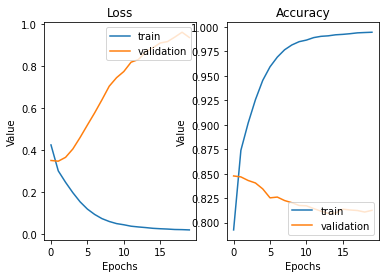

In [65]:
line_plot(model_conv_1D_history.epoch, model_conv_1D_history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

> train의 Accuracy, loss 그래프 모두 안정적인 학습 과정을 보여주었다.<br>
> validation의  Accuracy, loss 그래프에서는 불안정한 학습 과정을 보여주었다.<br>
> 결과적으로, 성능은 더욱 나빠지는 모습을 보여주고있다. 이는 과적합 현상임을 확인할 수 있다.

In [67]:
model_conv_1D.evaluate(X_test, y_test)

1251/1251 [==============================] - 7s 4ms/step - loss: 1.0048 - accuracy: 0.8039


[1.0048096179962158, 0.8039274215698242]

> 학습된 Convolution 1D 모델 성능을 테스트한 결과 loss는 1.0이고, 정확도는 80%라는 준수한 성능을 보여주었다.

## 7.3 Resut

> LSTM, Maxpool 1D, Convolution 1D 각각 3가지 모델을 활용하여 SentencePiece기반 토큰을 학습한 결과는 아래 표와 같다.<br>
> LSTM모델은 가장 낮은 성능을 보여주었으나, loss rate는 3가지 모델중 가장 낮은 모습을 보여주었다.<br>
> Maxpool 1D 모델은 LSTM와 비슷한 학습 파라미터를 보유했으나, 3가지 모델 중 가장 높은 정확도를 보여주었다.<br>
> Convolution 1D는 3가지 모델중 가장 적은 학슴 파라미터를 필요로 하면서, 동시에 Maxpool 1D와 유사한 성능을 보여주었다.

|모델명|parameter|accuracy|loss|
|------|---|---|---|
|LSTM|517,377|0.5808|<b>0.6642</b>|
|Maxpool 1D|505,041|<b>0.8268</b>|1.0366|
|Convolution 1D|<b>81,505</b> |0.8039|1.0048|

> 위 결과를 통해, Sentence piece 기반 토큰에 가장 적합한 모델은 Convolution 1D 모델이라 생각한다.

# 8. Research

> 본 8장에서는 위 실험에서 좋은 성능을 보여준 Convolution 1D 모델을 활용하여 Sentence piece 기반 토큰 외에 다른 토큰에서도 좋은 성능을 보여주는지 실험하는 과정을 기술한다.

## 8.1 Create token

> 본 8.1장에서는 Convolution 1D 모델에 사용하기위한 아래의 후보군 토큰을 생성하는 과정을 기술한다.
>
> + 공백 기반 토큰
> + 형태소 기반 토큰
> + Sentence Piece 기반 토큰 (실험완료)

### 8.1.1 공백 기반 토큰 생성

> keras 라이브러리의 Tokenizer()의 하이퍼 파라미터 filters에 공백 인자를 넣어 공백 기반 토큰을 생성하는 사용자 정의 함수를 구현한다.

In [33]:
def blank_space_tokenize(corpus):
    
    df_data = list()
    
    for sentence in corpus:
        df_data.append(sentence.split())
    blank_space_tokenizer.fit_on_texts(df_data)
    tensor = blank_space_tokenizer.texts_to_sequences(df_data)
    tensor = pad_sequences(tensor, padding='post', maxlen=70)

    return tensor

> train과 test 데이터간의 중복 토큰을 방지하기 위해 공백 토큰나이저 객체는 전역변수로 설정하고, 각 데이터의 토큰을 확보한다.

In [34]:
blank_space_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

blank_space_x_train = blank_space_tokenize(train_data["document"])
blank_space_x_test = blank_space_tokenize(test_data["document"])

> 공백으로 구분된 토큰을 어떻게 생성했는지 확인하고 토큰의 개수를 확인하는 작업을 진행한다.

In [35]:
for index, value in blank_space_tokenizer.index_word.items():
    if index > 20:
        break
        
    print("{} : {}".format(index, value))
    
print("\n 공백 기반 토큰 총 개수 : ", len(blank_space_tokenizer.index_word))

1 : 영화
2 : 너무
3 : 정말
4 : 진짜
5 : 이
6 : 영화.
7 : 왜
8 : 이런
9 : 그냥
10 : 더
11 : 수
12 : 최고의
13 : 잘
14 : 영화를
15 : 보고
16 : 본
17 : 좀
18 : 영화는
19 : 다
20 : 영화가

 공백 기반 토큰 총 개수 :  314737


> 200,000 여개의 네이버 영화 리뷰 데이터를 공백 기반으로 토큰화 한 결과, 314,737개의 토큰이 생성되었다.<br>
> 1, 6, 14, 18, 20번 인덱스를 보면 '영화'라는 같은 의미를 공유함에도 다른 단어로 인식함을 확인할 수 있다

### 8.1.2 형태소 기반 토큰 생성

> KoNLPy 라이브러리의 MeCab() 클래스 함수를 활용하여 형태소 기반 토큰을 생성하는 사용자 정의 함수를 구현한다.

In [36]:
def morpheme_tokenize(corpus):
    mecab_o = Mecab()
    df_data = []
    
    for sentence in corpus:
        df_data.append(mecab_o.morphs(sentence))

    morpheme_tokenizer.fit_on_texts(df_data)
    tensor = morpheme_tokenizer.texts_to_sequences(df_data)
    tensor = pad_sequences(tensor, padding='post', maxlen=70)
    
    return tensor

> train과 test 데이터간의 중복 토큰을 방지하기 위해 형태소 토큰나이저 객체는 전역변수로 설정하고, 각 데이터의 토큰을 확보한다.

In [37]:
morpheme_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

morpheme_x_train = morpheme_tokenize(train_data["document"])
morpheme_x_test = morpheme_tokenize(test_data["document"])

> 형태소로 구분된 토큰을 어떻게 생성했는지 확인하고 토큰의 개수를 확인하는 작업을 진행한다.

In [38]:
for index, value in morpheme_tokenizer.index_word.items():
    if index > 20:
        break
        
    print("{} : {}".format(index, value))
    
print("\n 형태소 기반 토큰 총 개수 : ", len(morpheme_tokenizer.index_word))

1 : .
2 : 이
3 : 는
4 : 영화
5 : 다
6 : 고
7 : 하
8 : 의
9 : 도
10 : 가
11 : 은
12 : 에
13 : 을
14 : 보
15 : ..
16 : 한
17 : !
18 : 게
19 : ,
20 : 지

 형태소 기반 토큰 총 개수 :  49875


> 200,000 여개의 네이버 영화 리뷰 데이터를 형태소 기반으로 토큰화 한 결과, 49,875개의 토큰이 생성되었다.<br>
> 의미가 중복되는 단어 없이 문법에 맞게 잘 분리되었음을 확인할 수 있다.

## 8.2 Token train for convolution 1D model

> 본 8.2장에서는 생성된 후보군의 토큰을 활용하여 Convolution 1D 모델에 학습하기위한 학습 데이터를 생성하고 훈련하는 과정을 기술한다.

### 8.2.1 Create train& validation dataset

> sklearn 라이브러리에서 모델 훈련에 사용하기 위한 데이터셋을 쉽게 생성할 수 있도록 제공하는 train_test_split()을 제공한다.<br>
> 위 함수를 활용하여 각 토큰의 훈련용 데이터셋과 검증용 데이터셋을 8:2 비율로 생성한다.

In [39]:
blank_space_x_train, blank_space_x_val, blank_space_y_train, blank_space_y_val = \
        train_test_split(blank_space_x_train, y_train, test_size=0.2, random_state=1996)

morpheme_x_train, morpheme_x_val, morpheme_y_train, morpheme_y_val = \
        train_test_split(morpheme_x_train, y_train, test_size=0.2, random_state=1996)

### 8.2.2 Conv1D model train for blank space token

In [51]:
blank_space_conv1d_model = tf.keras.Sequential()
blank_space_conv1d_model.add(tf.keras.layers.Embedding(len(blank_space_tokenizer.index_word)+10, 10, input_shape=(None,)))
blank_space_conv1d_model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
blank_space_conv1d_model.add(tf.keras.layers.MaxPooling1D(5))
blank_space_conv1d_model.add(tf.keras.layers.Conv1D(8, 5, activation='relu'))
blank_space_conv1d_model.add(tf.keras.layers.MaxPooling1D(5))
blank_space_conv1d_model.add(tf.keras.layers.Dense(4, activation='tanh'))
blank_space_conv1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
blank_space_conv1d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          3147470   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          816       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 8)           648       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

> 공백 기반 토큰을 활용한 Convolution 1D 모델을 설계한 결과, 3,148,975개의 파라미터를 훈련해야함을 확인할 수 있다.<br>
> 공백 기반 토큰의 임베딩 파라미터 개수가 많기에, 이에따라 학습할 파라미터의 개수도 많은 모습을 보여준다.

In [52]:
blank_space_conv1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
blank_space_conv1d_history = blank_space_conv1d_model.fit(blank_space_x_train, blank_space_y_train, epochs=10, validation_data=(blank_space_x_val, blank_space_y_val))

Epoch 1/10
2995/2995 [==============================] - 62s 20ms/step - loss: 0.5646 - accuracy: 0.6735 - val_loss: 0.4429 - val_accuracy: 0.7801
Epoch 2/10
2995/2995 [==============================] - 58s 19ms/step - loss: 0.1654 - accuracy: 0.9441 - val_loss: 0.5277 - val_accuracy: 0.7652
Epoch 3/10
2995/2995 [==============================] - 62s 21ms/step - loss: 0.0383 - accuracy: 0.9889 - val_loss: 0.6688 - val_accuracy: 0.7659
Epoch 4/10
2995/2995 [==============================] - 63s 21ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.8075 - val_accuracy: 0.7618
Epoch 5/10
2995/2995 [==============================] - 61s 20ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.9725 - val_accuracy: 0.7546
Epoch 6/10
2995/2995 [==============================] - 60s 20ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 1.0845 - val_accuracy: 0.7590
Epoch 7/10
2995/2995 [==============================] - 60s 20ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.2937 -

### 8.2.3 Conv1D model train for morpheme token

In [55]:
morpheme_conv1d_model = tf.keras.Sequential()
morpheme_conv1d_model.add(tf.keras.layers.Embedding(len(morpheme_tokenizer.index_word)+10, 10, input_shape=(None,)))
morpheme_conv1d_model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
morpheme_conv1d_model.add(tf.keras.layers.MaxPooling1D(5))
morpheme_conv1d_model.add(tf.keras.layers.Conv1D(8, 5, activation='relu'))
morpheme_conv1d_model.add(tf.keras.layers.GlobalMaxPooling1D())
morpheme_conv1d_model.add(tf.keras.layers.Dense(4, activation='tanh'))
morpheme_conv1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
morpheme_conv1d_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          498850    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          816       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 8)           648       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

> 형태소 기반 토큰을 활용한 Convolution 1D 모델을 설계한 결과, 500,355개의 파라미터를 훈련해야함을 확인할 수 있다.<br>
> 형태소 기반 토큰의 임베딩 파라미터 개수가 꽤 있기에, 이에따라 학습할 파라미터의 개수도 많은 모습을 보여준다.

In [56]:
morpheme_conv1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
morpheme_conv1d_history = morpheme_conv1d_model.fit(morpheme_x_train, morpheme_y_train, epochs=10, validation_data=(morpheme_x_val, morpheme_y_val))

Epoch 1/10
2995/2995 [==============================] - 21s 7ms/step - loss: 0.4977 - accuracy: 0.7472 - val_loss: 0.3473 - val_accuracy: 0.8508
Epoch 2/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.2866 - accuracy: 0.8853 - val_loss: 0.3456 - val_accuracy: 0.8516
Epoch 3/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.2107 - accuracy: 0.9208 - val_loss: 0.3606 - val_accuracy: 0.8508
Epoch 4/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.1575 - accuracy: 0.9435 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 5/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.1184 - accuracy: 0.9596 - val_loss: 0.4492 - val_accuracy: 0.8388
Epoch 6/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.0934 - accuracy: 0.9692 - val_loss: 0.4971 - val_accuracy: 0.8324
Epoch 7/10
2995/2995 [==============================] - 20s 7ms/step - loss: 0.0727 - accuracy: 0.9773 - val_loss: 0.5502 - val_ac

## 8.3 model test

> 본 8.3장에서는 8.2장에서 Convolution 1D 모델의 학습 과정을 살펴보고, Test 데이터셋을 활용하여 성능을 평가한다.

### 8.3.1 Conv1D model test for blank space token

> 공백 기반 토큰을 학습한 Convoluton 1D 모델의 학습 과정은 아래 그림과 같다.

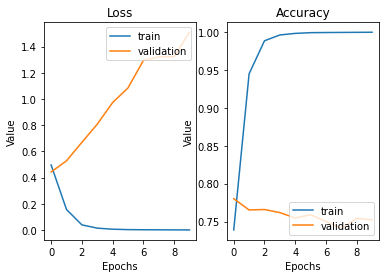

In [59]:
line_plot(blank_space_conv1d_history.epoch, blank_space_conv1d_history.history, ['loss', 'val_loss','accuracy', 'val_accuracy'])

> train의 Accuracy, loss 그래프 모두 안정적인 학습 과정을 보여주었다.<br>
> validation의  Accuracy, loss 그래프에서는 성능이 역행하는 모습을 보여주었다.<br>

In [54]:
blank_space_conv1d_model.evaluate(blank_space_x_test, y_test)

1251/1251 [==============================] - 3s 2ms/step - loss: 3.7523 - accuracy: 0.5059


[3.752335548400879, 0.5058961510658264]

> 공백 기반 토큰을 학습한 Convolution 1D 모델 성능을 테스트한 결과 loss는 3.7이고, 정확도는 50%라는 낮은 성능을 보여주었다.

### 8.3.2 Conv1D model test for morpheme token

> 형태소 기반 토큰을 학습한 Convoluton 1D 모델의 학습 과정은 아래 그림과 같다.

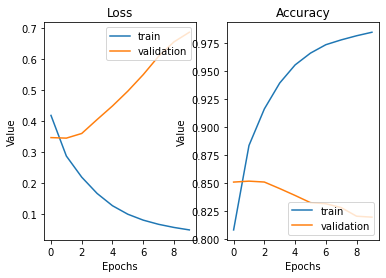

In [60]:
line_plot(morpheme_conv1d_history.epoch, morpheme_conv1d_history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

> train의 Accuracy, loss 그래프 모두 안정적인 학습 과정을 보여주었다.<br>
> validation의  Accuracy, loss 그래프에서는 값은 안정적으로 수렴하나, 성능은 반대로 나빠지는 모습을 보여주었다.

In [58]:
morpheme_conv1d_model.evaluate(morpheme_x_test, y_test)

1251/1251 [==============================] - 3s 2ms/step - loss: 1.8114 - accuracy: 0.5803


[1.8114036321640015, 0.5802978277206421]

> 형태소 기반 토큰을 학습한 Convolution 1D 모델 성능을 테스트한 결과 loss는 1.8이고, 정확도는 58%인 결과를 확인할 수 있다.

## 8.4 Result

> 각각 공백, 형태소, 문장 조각 기법을 활용하여 토큰을 생성하고, 각 토큰을 Convolution 1D모델로 학습한 결과는 아래 표와 같다.

|모델|토큰 종류|train parameter|test_accuracy|test_loss|
|---|------|---|---|---|
|Convolution 1D|공백(Blank Space)|3,148,975|0.5059|3.7523|
|Convolution 1D|형태소(morpheme)|500,355|0.5803|1.8114|
|Convolution 1D|문장 조각(Sentence Piece)|<b>81,505</b> |<b>0.8039</b>|<b>1.0048</b>|

> 공백(Blank Space) 토큰 기반 Conv1D 모델은 3가지 비교군에서 가장 낮은 성능을 보여주었다.<br>
> 또한, 학습에 필요한 학습 파라미터가 너무 많아 학습 시간도 비교군에 비해 오래 걸리는 모습을 보여주었다.<br>
> <br>
> 
> 형태소(morpheme) 토큰 기반 Conv1D 모델은 3가지 비교군에서 2번째로 낮은 성능을 보여주었다.<br>
> 공백 기반 토큰 모델에 비해, 학습 파라미터가 1/6로 크게 감소했으며, test_loss도 절반으로 감소한 모습을 확인할 수 있다.<br>
> 그러나 test_accuracy의 성능이 낮아 실 사용에는 활용하기에는 부족하다는 문제가 있다.<br>
> <br>
> 문장 조각(Sentence Piece) 토큰 기반 Conv1D 모델은 3가지 비교군에서 가장 높은 성능을 보여주었다.<br>
> test_accuracy는 80%이며, test_loss 또한 1.0으로 준수한 성능으로 프로토타입 서비스에 활용할 수 있음을 보여주었다.<br>
> 특히, 학습 파라미터는 공백 기반 토큰 모델 대비 2.5%으로 매우 적은 학습 파라미터 개수를 보여주었다.<br>
> 이는 모델의 학습에 소요되는 시간이 감소되는 장점을 얻을 수 있다.